[View in Colaboratory](https://colab.research.google.com/github/ronteo/machinelearningproject/blob/master/rnn_visualization.ipynb)

In [2]:
import pickle
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd

% matplotlib inline

Using TensorFlow backend.


In [3]:
path = get_file('imdb_full.pkl',
           origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
           md5_hash='d091312047c43cf9e4e38fef92437263')

#Split into train/test, and separate features from labels
f = open(path, 'rb')
(X_train, y_train), (X_test, y_test) = pickle.load(f)

X_train = np.array(sequence.pad_sequences([np.array(x) for x in X_train], maxlen=MAXLEN))
y_train =np.array(y_train)
X_test = np.array(sequence.pad_sequences([np.array(x) for x in X_test], maxlen=MAXLEN))
y_test = np.array(y_test)

65568768/65552540 [==============================] - 6s 0us/step


NameError: ignored

In [0]:

import keras

def build_model():
    initi = keras.initializers.Constant(value=.5)
    biniti = keras.initializers.Constant(value=1)
    input_layer = Input(shape=(2, 3 ), name='input_layer', dtype='float32')
    X = keras.layers.LSTM(1,kernel_initializer=initi, bias_initializer=biniti, return_sequences=True)(input_layer)
    last_step_layer = Lambda(lambda x: x[:, -1, :], output_shape=(rnn_hidden_dim, ), name='last_step_layer')(X)  
    
    
    #embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=maxlen, trainable=True, mask_zero=False, name='embedding_layer')(input_layer)  # -- ideally mask_zero=False but can't work with lambda layers
    #recurrent_layer = LSTM(output_dim=rnn_hidden_dim, activation='tanh', return_sequences=True, name='recurrent_layer')(embedding_layer)
    #last_step_layer = Lambda(lambda x: x[:, -1, :], output_shape=(rnn_hidden_dim, ), name='last_step_layer')(recurrent_layer)  # only needed for visualization
    #logit = Dense(1, name='logit_layer')(last_step_layer)
    #output_layer = Activation('sigmoid', name='output_layer')(logit)
    
    optimizer = Adam(lr=0.001)
    model = Model(input=input_layer, output=X)
    print('Compiling...')
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
    return model

In [173]:
model = build_model()
grads = K.gradients(model.output, model.input)

grad = K.function([model.input],  [grads[0]])
grad([np.reshape(ex1, (1,2,3))])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ls..., inputs=Tensor("in...)`


Compiling...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 2, 3)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


[array([[[1.7664044e-05, 1.7664044e-05, 1.7664044e-05],
         [5.3725130e-04, 5.3725130e-04, 5.3725130e-04]]], dtype=float32)]

In [142]:
ex1 = np.array([[1.5,2.5,3.0], [-1.5,2.5,3.0]])
ex2 = [-1.5,2.5,3.0]
ex3 = [1.5,2.5,-3.0]


ex1.shape

(2, 3)

In [160]:

#ex1 =[ex1, ex2]






Compiling...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 2, 3)              0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("gr..., inputs=Tensor("in...)`


In [0]:
from __future__ import print_function

from keras import backend as K
from keras.engine import Input, Model, InputSpec
from keras.layers import Dense, Activation, Dropout, Lambda
from keras.layers import Embedding, LSTM
from keras.optimizers import Adam

from keras.utils.data_utils import get_file
from keras.datasets import imdb
import random
import sys
import pdb

MAX_FEATURES = 20000
MAXLEN = 80
BATCH_SIZE = 32
STEP = 3
EMBEDDING_DIM = 128
RNN_HIDDEN_DIM = 128

# TODO: add normalization
# TODO: activation cluster?
# TODO: get forget gates from LSTMs (not sure how to grab temporary tensors inside loops)


def build_vocab():
    vocab = imdb.get_word_index()
    rev_vocab = {v: k for k, v in vocab.iteritems()}
    return vocab, rev_vocab


def vectorize(text, vocab, 
              maxlen=MAXLEN, start_char=1, oov_char=2, index_from=3):
    """ might not be consistent with vectorize_data. """
    if isinstance(text, basestring):
        text = [text]
    v = [[vocab.get(w, oov_char) for w in t.lower().split()] for t in text]
    return sequence.pad_sequences(v, maxlen=maxlen)


def vectorize_data(max_features=MAX_FEATURES, maxlen=MAXLEN, batch_size=BATCH_SIZE, limit=None):

    print('Loading data...')
    (X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)
    print(len(X_train), 'train sequences')
    print(len(X_test), 'test sequences')

    print('Pad sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    if limit is None:
        return X_train, y_train, X_test, y_test
    else:
        return X_train[:limit], y_train[:limit], X_test[:limit], y_test[:limit]


def build_model(vocab_size, maxlen=MAXLEN, rnn_hidden_dim=RNN_HIDDEN_DIM):
    input_layer = Input(shape=(maxlen, ), name='input_layer', dtype='int32')
    embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=maxlen, trainable=True, mask_zero=False, name='embedding_layer')(input_layer)  # -- ideally mask_zero=False but can't work with lambda layers
    recurrent_layer, _, _ = LSTM(output_dim=rnn_hidden_dim, activation='tanh', return_sequences=True, return_state=True, name='recurrent_layer')(embedding_layer)
    last_step_layer = Lambda(lambda x: x[:, -1, :], output_shape=(rnn_hidden_dim, ), name='last_step_layer')(recurrent_layer)  # only needed for visualization
    logit = Dense(1, name='logit_layer')(last_step_layer)
    output_layer = Activation('sigmoid', name='output_layer')(logit)
    
    optimizer = Adam(lr=0.001)
    model = Model(input=input_layer, output=output_layer)
    print('Compiling...')
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
    return model


def visualize_model(model, include_gradients=False):
    recurrent_layer = model.get_layer('recurrent_layer')
    logit_layer = model.get_layer('logit_layer')
    output_layer = model.get_layer('output_layer')
    embedding_layer = model.get_layer('embedding_layer')
    
    
    recurrent_layer_output, _,  _ = recurrent_layer.output
    
    inputs = []
    inputs.extend(model.inputs)

    outputs = []
    outputs.extend(model.outputs)
    outputs.append(recurrent_layer_output)
    outputs.append(recurrent_layer.cell.kernel_f)  # -- weights of the forget gates (assuming LSTM)
    outputs.append(logit_layer.output)
    
    
    if include_gradients:
      loss = K.mean(model.output)  # [batch_size, 1] -> scalar   #Why is the mean of the output the loss? The ouput of the sigmoid is the loss?? Mean of a scalar??? why? since mean of scalar is just the scalar?
      #loss = model.output
      print("loss.shape{}".format(loss.shape))
      grads = K.gradients(loss, embedding_layer.output)[0] # Partial derivative  or total derivate ? I think I want stop since I want to conisder the consider only the contributions of x's of loss wrt the output of the LSTM. Showing how a small change in the output of the recurrent will affect our loss, in this case, how it affects the output.
      #print("grads.shape{}".format(len(grads)))                                                 
      #grads_norm = grads / (K.sqrt(K.mean(K.square(grads))) + 1e-5) # Do I want to take the mean of the encoding? Do I want abs/positive grads? absolute?
      outputs.append(grads)

    all_function = K.function(inputs, outputs)
    output_function = K.function([logit_layer.input], model.outputs)
    return all_function, output_function


def get_compare_embeddings(original_embeddings, tuned_embeddings, vocab, dimreduce_type="pca", random_state=0):
    """ Compare embeddings drift. """
    if dimreduce_type == "pca":
        from sklearn.decomposition import PCA
        dimreducer = PCA(n_components=2, random_state=random_state)
    elif dimreduce_type == "tsne":
        from sklearn.manifold import TSNE
        dimreducer = TSNE(n_components=2, random_state=random_state)
    else:
        raise Exception("Wrong dimreduce_type.")

    reduced_original = dimreducer.fit_transform(original_embeddings)
    reduced_tuned = dimreducer.fit_transform(tuned_embeddings)

    def compare_embeddings(word):
        if word not in vocab:
            return None
        word_id = vocab[word]
        original_x, original_y = reduced_original[word_id, :]
        tuned_x, tuned_y = reduced_tuned[word_id, :]
        return original_x, original_y, tuned_x, tuned_y

    return compare_embeddings


vocab, rev_vocab = build_vocab()

In [1]:
recurrent_layer = model.get_layer('recurrent_layer')
out, state_h, _  = recurrent_layer.output
print(state_h)
out

NameError: ignored

In [73]:
embedding_layer = model.get_layer('embedding_layer')
type(embedding_layer.output)

tensorflow.python.framework.ops.Tensor

In [50]:
model.inputs[0]

<tf.Tensor 'input_layer_3:0' shape=(?, 80) dtype=int32>

In [81]:
all_function, output_function = visualize_model(model, include_gradients=True)

loss.shape()


In [70]:
if __name__ == '__main__':
    # -- train
    #vocab, rev_vocab = build_vocab()
    # Get full dataset (copied from Keras)
    #path = get_file('imdb_full.pkl',
    #            origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
    #            md5_hash='d091312047c43cf9e4e38fef92437263')

    # Split into train/test, and separate features from labels
    #f = open(path, 'rb')
    #(np.array(X_train), np.array(y_train)), ((np.array(X_test), np.array(y_test)) = pickle.load(f)
    
    #X_train, y_train, X_test, y_test = vectorize_data()
    model = build_model(len(vocab))
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=1, verbose=True, # validation_split=0.05)
              validation_data=(X_test, y_test))

    acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print('Test accuracy:', acc)

    # -- predict
    all_function, output_function = visualize_model(model, include_gradients=True)

    t = "HOW COULD anything originate out of its opposite?".lower()
    X = vectorize(t, vocab)
    
    # -- Return scores, raw rnn values and gradients
    # scores is equivalent to model.predict(X)
    scores, rnn_values, W_i, logits, rnn_gradients = all_function([X])
    print("scores.shape: {}, rnn_values.shape: {}, rnn_gradients.shape: {}, W_i.shape: {}".format(scores.shape, rnn_values.shape, rnn_gradients.shape, W_i.shape))

    # -- score prediction
    print("Scores:", scores)

    # -- Return scores at each step in the time sequence
    time_distributed_scores = map(lambda x: output_function([x]), rnn_values)
    print("Time distributed (word-level) scores:", map(lambda x: x[0], time_distributed_scores))


    # -- if you have original embeddings, use here
    embeddings = model.get_weights()[0]
    compare_embeddings = get_compare_embeddings(embeddings, embeddings, vocab, dimreduce_type="pca", random_state=0)
    print("Embeddings drift:", compare_embeddings('d'))
    
    
    model.save("model.hdf5")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(name="recurrent_layer", return_state=True, activation="tanh", units=128, return_sequences=True)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:70: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ou..., inputs=Tensor("in...)`


Compiling...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 80)                0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 80, 128)           11338752  
_________________________________________________________________
recurrent_layer (LSTM)       [(None, 80, 128), (None,  131584    
_________________________________________________________________
last_step_layer (Lambda)     (None, 128)               0         
_________________________________________________________________
logit_layer (Dense)          (None, 1)                 129       
_________________________________________________________________
output_layer (Activation)    (None, 1)                 0         
Total params: 11,470,465
Trainable params: 11,470,465
Non-trainable params: 0
___________________________________________________

 7040/25000 [=======>......................] - ETA: 31s

25000/25000 [==============================] - 44s 2ms/step
Test accuracy: [0.37429480922698977, 0.83524]
loss.shape()


TypeError: ignored

In [0]:
recurrent_layer = model.get_layer('recurrent_layer')

In [0]:
#model = load_model('model.hdf5')

In [6]:

all_function, output_function = visualize_model(model, include_gradients=True)

loss.shape(?, 1)


ValueError: ignored

# Visualization

In [0]:
# -- Return scores, raw rnn values and gradients
# scores is equivalent to model.predict(X)
def getVisualization(review):
  t = review.lower()
  X = vectorize(t, vocab)
  scores, rnn_values, W_i, logits, rnn_gradients = all_function([X])
  return scores, rnn_values, W_i, logits, rnn_gradients


def get_df(data, review, padding=3):
  
  review_tokens =  review.split(" ")
  sentence_len =   len(review_tokens)

  num_seq = sentence_len + padding

  #x = np.transpose(np.squeeze(data)[-(sentence_len + padding):,:])
  x = np.transpose(np.squeeze(data)[-num_seq:,])

  words = np.squeeze(sequence.pad_sequences([review_tokens], maxlen= sentence_len + padding, dtype='string'))
    
  return pd.DataFrame(data=np.squeeze(x), columns=words)

def get_df_2(data, review, padding=3):

  review_tokens =  review.split(" ")
  sentence_len =   len(review_tokens)

  num_seq = sentence_len + padding
  x = np.reshape(np.squeeze(data),(1,-1))[:,-num_seq:]

  words = np.squeeze(sequence.pad_sequences([review_tokens], maxlen= num_seq, dtype='string'))

  return pd.DataFrame(data=x, columns = words)




In [175]:
scores, rnn_values, W_i, logits,rnn_gradients = getVisualization("")
#print(rnn_gradients.shape)
#rnn_gradients[-1]
#get_df(rnn_gradients, 'this is a bad movie')
#get_df(rnn_gradients, 'This is a bad movie. The sky is so high I could fly')
np.squeeze(rnn_gradients)[0][0]

0.0

In [58]:


scores, rnn_values, W_i, logits,rnn_gradients = getVisualization("Hi")
rnn_gradients

array([[[-8.4931190e-07,  8.3018995e-07,  1.5282781e-06, ...,
          1.6263962e-06,  1.2196409e-06, -2.6524938e-06],
        [-9.5705991e-07,  9.2584941e-07,  1.7024404e-06, ...,
          1.7738878e-06,  1.3525149e-06, -2.9045445e-06],
        [-1.0790561e-06,  1.0375427e-06,  1.9022334e-06, ...,
          1.9432848e-06,  1.5037923e-06, -3.1958305e-06],
        ...,
        [ 2.7788496e-02,  1.2600323e-02,  4.4466485e-03, ...,
          2.1094881e-02,  8.4596341e-03, -4.2454764e-02],
        [ 4.2137243e-02,  1.5805140e-02,  1.8903933e-03, ...,
          2.6929010e-02,  6.8867602e-03, -5.6634378e-02],
        [ 5.6880083e-02,  1.9530041e-02, -4.0069968e-03, ...,
          2.4829777e-02,  4.0087495e-03, -6.4952858e-02]]], dtype=float32)

In [58]:
plt.get_cmap("RdBu_r")

In [0]:
def plot(reviews):
  palette = plt.get_cmap("RdBu_r")
  #palette = sns.color_palette("RdBu_r", 7)
  f, ax = plt.subplots(figsize=(25, 20), nrows=2, ncols=4, sharey=True)
 
  for j, review in enumerate(reviews):
    
    scores, rnn_values, W_i, logits, rnn_gradients = getVisualization(review)
    
    rnn_activations = get_df(rnn_values, review)
    
    time_distributed_scores = map(lambda x: output_function([x]), rnn_values)
    time_distributed_scores = get_df_2(time_distributed_scores, review)
    
    ax[0][j].set_title("GRU Hidden Layer Activations\nScore:{:.2f}".format(scores[0][0]))
    sns.heatmap(data = rnn_activations, fmt=".2f", linewidths=.5, ax=ax[0][j], cmap=palette)
    
    ax[1][j].set_title("GRU Time Distributed Scores \nScore:{:.2f}".format(scores[0][0]))
    sns.heatmap(data = time_distributed_scores, fmt=".2f", linewidths=.5, ax=ax[1][j], cmap=palette)
    

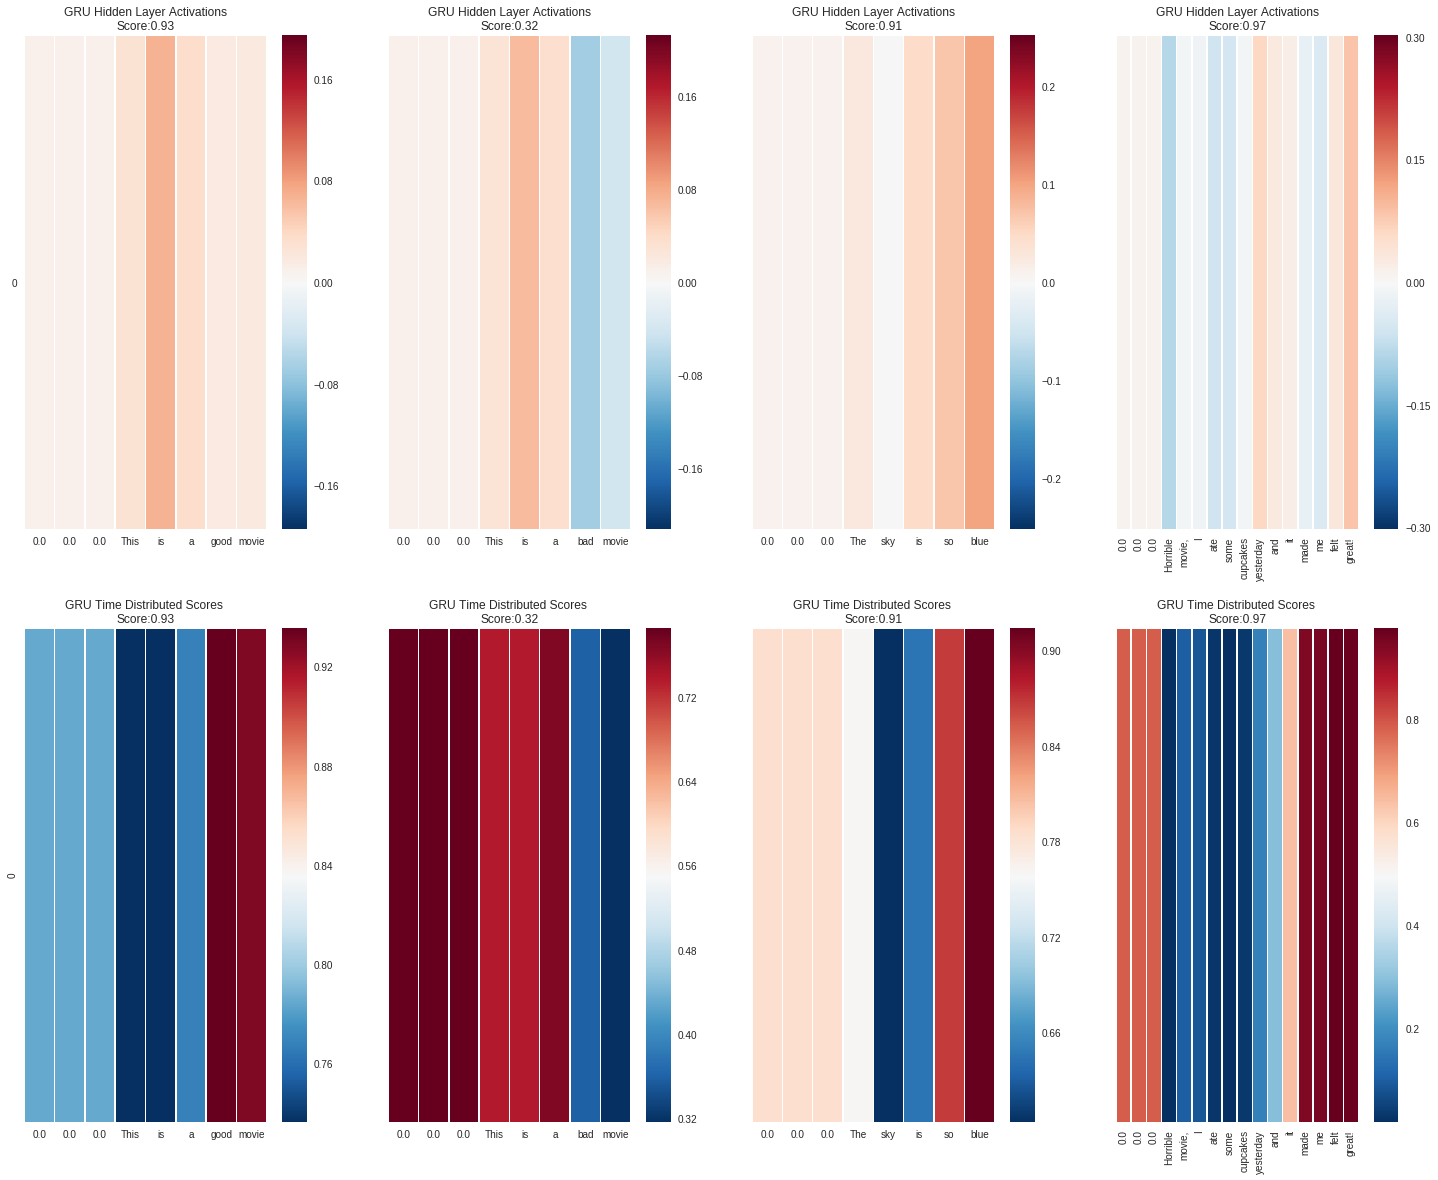

In [66]:
reviews = ['This is a good movie', 'This is a bad movie', 'The sky is so blue', 'Horrible movie, I ate some cupcakes yesterday and it made me felt great!']

plot(reviews)

In [19]:
t = "this is a good movie".lower()
X = vectorize(t, vocab)

# -- Return scores, raw rnn values and gradients
# scores is equivalent to model.predict(X)
scores, rnn_values, rnn_gradients, W_i = all_function([X])
scores

array([[0.80246824]], dtype=float32)

In [12]:
labels_test[12]

1

In [30]:
ex = " ".join([rev_vocab[word] for word in x_test[12] if word in rev_vocab])
ex

u"i first saw this movie on ifc which is a great network by the way to see underground films i watched this movie and was thinking it was going to be pure drama and a story line that doesn't hold water but it really was a worth while watch the main character is in such rough shape and you hate to see him deny help but no matter what you just can't hate him his devotion to the beatles and john lennon is a great metaphor for his life and the helplessness he feels br br the atmosphere of the film is also great at times you feel like you can see what he sees feel what he feels in some situations this movie does not leave you wanting to know more or disliking a loophole in the plot there are no loopholes in my opinion i have always been a fan of foreign films especially now with movies being made so poorly in america i really enjoy the foreign settings because i feel it can take you on a trip and sometimes understand a different culture this movie did all those things to me and more please 

In [0]:
loss = K.mean(model.output)  # [batch_size, 1] -> scalar   #Why is the mean of the output the loss? The ouput of the sigmoid is the loss?? Mean of a scalar??? why? since mean of scalar is just the scalar?
print("loss.shape{}".format(loss.shape))
grads = K.gradients(loss, recurrent_layer.output) # Partial derivative of loss wrt the output of the LSTM. Showing how a small change in the output of the recurrent will affect our loss, in this case, how it affects the output.
print("grads.shape{}".format(len(grads)))                                                  #Is this what we want? Or do we want the gradient wrt the input? I guess not because we want to consider the effect of the sequence rather than the indep input.
grads_norm = grads / (K.sqrt(K.mean(K.square(grads))) + 1e-5)
outputs.append(grads_norm)


In [0]:
vectorize(ex,vocab).shape

(1, 80)

In [0]:
output = np.zeros((10,1))
K.mean(o
       
       
       
       
       
       
utput)

AttributeError: ignored

In [25]:
 X_train, y_train, X_test, y_test = vectorize_data()

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 80)
X_test shape: (25000, 80)


In [27]:
" ".join([rev_vocab[word] for word in X_test[12] if word in rev_vocab])

u"encounter wit understand not director main of hate br doesn't of you was attempt why this enough cult or of sequel missed lovable as problem on it had world francis to mercilessly film films for against also and adds that's but only producing to so shocked wouldn't br think now cut was nothing which same that played this is producer do on actor really it sam but we he's was did is quite br around rigid many final why typical"